In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.colors import LogNorm
import copy

# Fixing random state for reproducibility
np.random.seed(19680801)

# Logical Volume

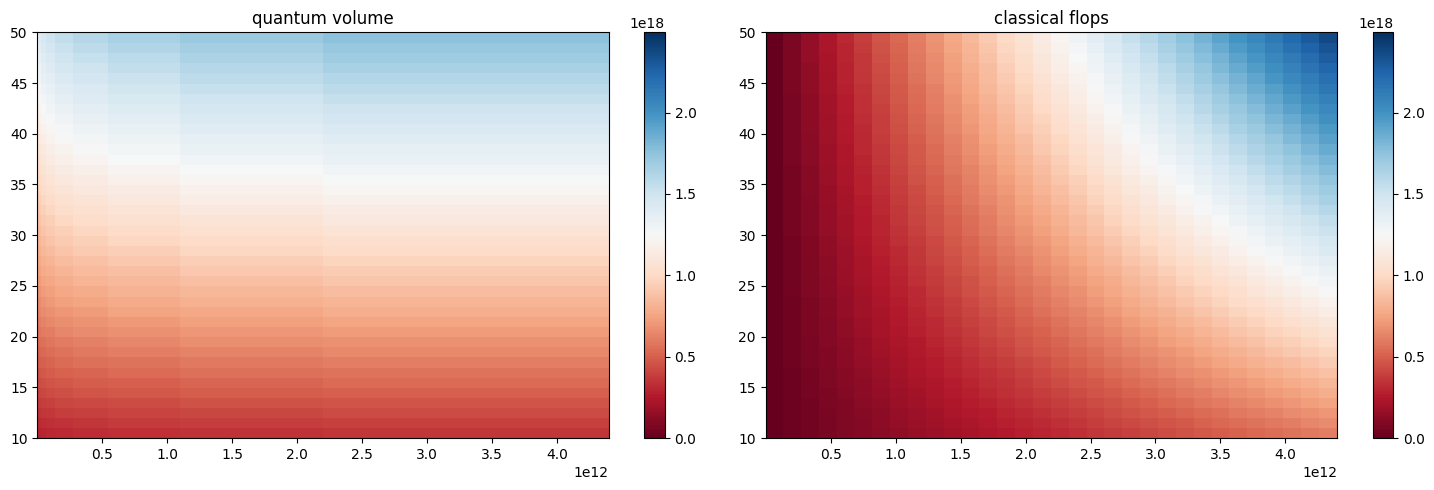

In [3]:
def plot_logical_volume(): # set this function to avoid conflict variables
    s_start = 10
    s_end = 50
    ds = 1

    k = 1000
    epsilon = 0.01
    bits = 10


    n_start = 10
    n_end = 42
    dn = 1

    s, n = np.mgrid[s_start:s_end+ds:ds, n_start:n_end + dn:dn]

    # quantum volume
    nhs = np.sqrt(80 / 3) * np.pi * k**2 * s / epsilon**2 # here we assume that there are s summands
    q_alg_phs = bits + 2 * n + 2
    q_lgc_phs = 2 * q_alg_phs + np.ceil(np.sqrt(8 * q_alg_phs)) + 1
    log_depth_phs = 10 * n + 609
    volumn = nhs * q_lgc_phs * log_depth_phs

    # classical volume
    N_start = 2**n_start
    N_end = 2**n_end
    N_steps = n_end - n_start
    dN = (N_end - N_start) / N_steps

    _, N = np.mgrid[s_start:s_end+ds:ds, N_start:N_end + dN:dN]

    flops = 0.5 * k * np.log(2 / epsilon) * (4 * N * s + 14 * N)


    # plot
    fig, axs = plt.subplots(1,2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

    all_min = min(np.min(volumn), np.min(flops))
    all_max = max(np.max(volumn), np.max(flops))

    ax = axs[0]
    c = ax.pcolor(2**n, s, volumn[:-1,:-1], cmap='RdBu', vmin=all_min, vmax=all_max)
    ax.set_title('quantum volume')
    fig.colorbar(c, ax=ax)

    ax = axs[1]
    c = ax.pcolor(N, s, flops[:-1,:-1], cmap='RdBu', vmin=all_min, vmax=all_max)
    ax.set_title('classical flops')
    fig.colorbar(c, ax=ax)

    plt.tight_layout()
    plt.show()

plot_logical_volume()

# Runtime

ValueError: Integers to negative integer powers are not allowed.

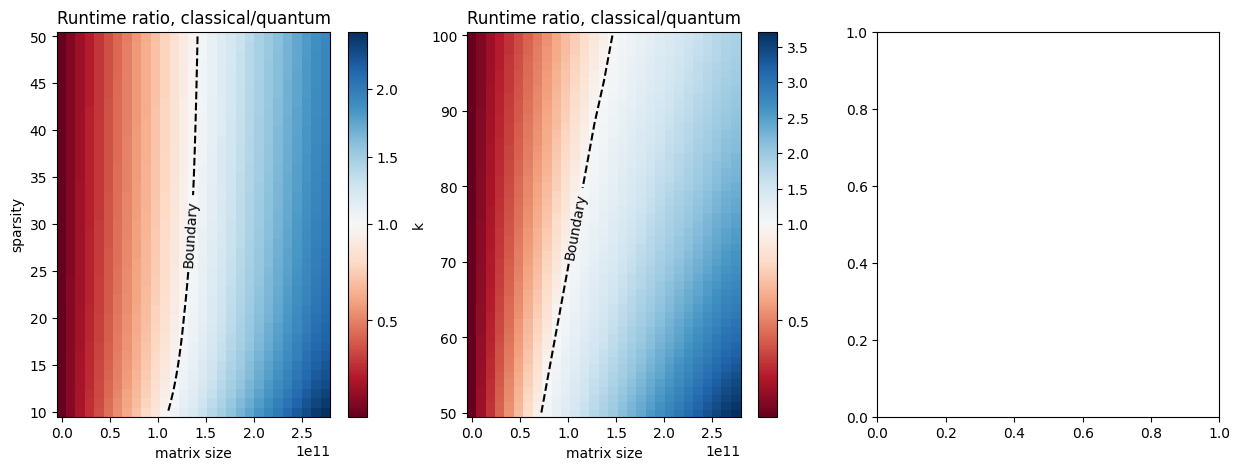

In [ ]:
def plot_runtime():  # set this function to avoid conflict variables

    def sub_plot(ax, x,y, data, title, xlabel, ylabel):
        norm = colors.TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())
        c = ax.pcolor(x, y, data, cmap="RdBu", norm=norm)
        ax.set_title(title)
        fig.colorbar(c, ax=ax)   

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        contour = ax.contour(
            x,
            y,
            data,
            levels=[1],
            colors="black",
            linewidths=1.5,
            linestyles="--",
        )
        ax.clabel(contour, fmt="Boundary", fontsize = 10,colors="black")

    def calculate_q_runtime(k, s, epsilon, n):
        per_hs_runtime = (3000000 + 70000 * n) * 1e-9
        nhs = (
            np.sqrt(80 / 3) * np.pi * k**2 * s / np.power(10.0,-epsilon) ** 2
        )  # here we assume that there are s summands

        return nhs * per_hs_runtime

    def calculate_c_runtime(k, s, epsilon, N):
        flops = 0.5 * k * np.log(2 / np.power(10.0, -epsilon)) * (4 * N * s + 14 * N)
        return flops * 1e-9

    def calculate_ratio(q_runtime, c_runtime, N, n_start):
        ratio = c_runtime
        for i in range(0, N.shape[0]):
            for j in range(0, N.shape[1]):
                q_j= np.floor(np.log2(N[i, j])).astype(int) - n_start
                ratio[i, j] = ratio[i, j] / q_runtime[i, q_j]
        return ratio

    s_start, s_end, ds = 10, 50, 1
    k_start, k_end, dk = 50, 100, 1
    epsilon_start, epsilon_end, depslilon = 1, 4, 1

    fix_k, fix_epsilon, fix_s = 100, 1, 100
    n_start, n_end, dn = 10, 38, 1

    # big N used by classical plot
    N_start = 2**n_start
    N_end = 2**n_end
    N_steps = n_end - n_start
    dN = (N_end - N_start) / N_steps

    fig, axs = plt.subplots(1,3,figsize=(15, 5))

    ###############################
    # n - s
    ###############################
    s, n = np.mgrid[s_start : s_end + ds : ds, n_start : n_end + dn : dn]
    _, n_s_N = np.mgrid[s_start : s_end + ds : ds, N_start : N_end + dN : dN]

    n_s_q_runtime = calculate_q_runtime(fix_k, s, fix_epsilon, n)
    n_s_c_runtime = calculate_c_runtime(fix_k, s, fix_epsilon, n_s_N)
    n_s_ratio = calculate_ratio(n_s_q_runtime, n_s_c_runtime, n_s_N, n_start)

    sub_plot(axs[0], n_s_N, s, n_s_ratio, "Runtime ratio, classical/quantum", "matrix size", "sparsity")

    ###############################
    # k - n
    ###############################
    k, n = np.mgrid[k_start : k_end + dk : dk, n_start : n_end + dn : dn]
    _, n_k_N = np.mgrid[k_start : k_end + dk : dk, N_start : N_end + dN : dN]
    n_k_q_runtime = calculate_q_runtime(k, fix_s, fix_epsilon, n)
    n_k_c_runtime = calculate_c_runtime(k, fix_s, fix_epsilon, n_k_N)
    n_k_ratio = calculate_ratio(n_k_q_runtime, n_k_c_runtime, n_k_N, n_start)

    sub_plot(axs[1], n_k_N, k, n_k_ratio, "Runtime ratio, classical/quantum", "matrix size", "k")

    ###############################
    # epsilon - n
    ###############################
    epsilon, n = np.mgrid[epsilon_start : epsilon_end + depslilon : depslilon, n_start : n_end + dn : dn]
    _, n_epsilon_N = np.mgrid[epsilon_start : epsilon_end + depslilon : depslilon, N_start : N_end + dN : dN]
    n_epsilon_q_runtime = calculate_q_runtime(fix_k, fix_s, epsilon, n)
    n_epsilon_c_runtime = calculate_c_runtime(fix_k, fix_s, epsilon, n_epsilon_N)
    n_epsilon_ratio = calculate_ratio(n_epsilon_q_runtime, n_epsilon_c_runtime, n_epsilon_N, n_start)

    sub_plot(axs[2], n_epsilon_N, epsilon, n_epsilon_ratio, "Runtime ratio, classical/quantum", "matrix size", "epsilon")

    plt.tight_layout()

    plt.show()


plot_runtime()

## Runtime

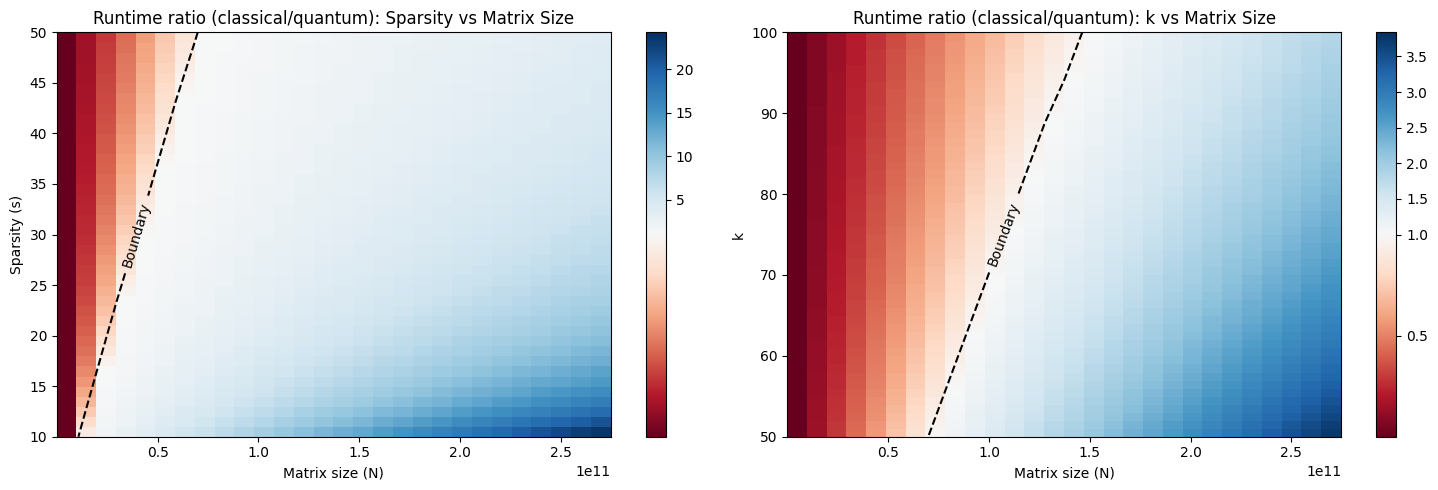

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors


def calculate_runtime(param_grid, fixed_param, fix_epsilon, n_start, per_hs_runtime):
    nhs = (
        np.sqrt(80 / 3)
        * np.pi
        * param_grid**2
        * fixed_param
        / (10 ** (-fix_epsilon)) ** 2
    )
    q_runtime = nhs * per_hs_runtime
    return q_runtime


def calculate_classical_runtime(param_grid, N_grid, fix_k, fix_epsilon):
    flops = (
        0.5
        * fix_k
        * np.log(2 / (10 ** (-fix_epsilon)))
        * (4 * N_grid * param_grid + 14 * N_grid)
    )
    c_runtime = flops * 1e-9
    return c_runtime


def compute_ratio(c_runtime, q_runtime, N_grid, n_start):
    ratio = c_runtime.copy()
    for i in range(N_grid.shape[0]):
        for j in range(N_grid.shape[1]):
            q_j = np.floor(np.log2(N_grid[i, j])).astype(int) - n_start
            ratio[i, j] /= q_runtime[i, q_j]
    return ratio


def plot_heatmap(ax, X, Y, Z, title, xlabel, ylabel):
    norm = colors.TwoSlopeNorm(vmin=Z.min(), vcenter=1, vmax=Z.max())
    c = ax.pcolor(X, Y, Z[:-1, :-1], cmap="RdBu", norm=norm)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    contour = ax.contour(
        X, Y, Z, levels=[1], colors="black", linewidths=1.5, linestyles="--"
    )
    ax.clabel(contour, fmt="Boundary", fontsize=10, colors="black")
    return c


def plot_runtime():
    s_start, s_end, ds = 10, 50, 1
    k_start, k_end, dk = 50, 100, 1
    fix_k, fix_epsilon, fix_s = 100, 1, 100
    n_start, n_end, dn = 10, 38, 1

    N_start, N_end, N_steps = 2**n_start, 2**n_end, n_end - n_start
    dN = (N_end - N_start) / N_steps

    s, n = np.mgrid[s_start : s_end + ds : ds, n_start : n_end + dn : dn]
    _, n_s_N = np.mgrid[s_start : s_end + ds : ds, N_start : N_end + dN : dN]
    per_hs_runtime = (3000000 + 70000 * n) * 1e-9

    n_s_q_runtime = calculate_runtime(s, fix_k, fix_epsilon, n_start, per_hs_runtime)
    n_s_c_runtime = calculate_classical_runtime(s, n_s_N, fix_k, fix_epsilon)
    n_s_ratio = compute_ratio(n_s_c_runtime, n_s_q_runtime, n_s_N, n_start)

    k, n = np.mgrid[k_start : k_end + dk : dk, n_start : n_end + dn : dn]
    _, n_k_N = np.mgrid[k_start : k_end + dk : dk, N_start : N_end + dN : dN]
    per_hs_runtime = (3000000 + 70000 * n) * 1e-9

    n_k_q_runtime = calculate_runtime(k, fix_s, fix_epsilon, n_start, per_hs_runtime)
    n_k_c_runtime = calculate_classical_runtime(k, n_k_N, fix_k, fix_epsilon)
    n_k_ratio = compute_ratio(n_k_c_runtime, n_k_q_runtime, n_k_N, n_start)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    c1 = plot_heatmap(
        axs[0],
        n_s_N,
        s,
        n_s_ratio,
        "Runtime ratio (classical/quantum): Sparsity vs Matrix Size",
        "Matrix size (N)",
        "Sparsity (s)",
    )
    fig.colorbar(c1, ax=axs[0])

    c2 = plot_heatmap(
        axs[1],
        n_k_N,
        k,
        n_k_ratio,
        "Runtime ratio (classical/quantum): k vs Matrix Size",
        "Matrix size (N)",
        "k",
    )
    fig.colorbar(c2, ax=axs[1])

    plt.tight_layout()
    plt.show()


plot_runtime()